In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pprint

In [48]:
with open("data/input.txt","r",encoding="utf-8")as f:
    text=f.read()
len(text)
pprint.pprint(text[:1000])

('First Citizen:\n'
 'Before we proceed any further, hear me speak.\n'
 '\n'
 'All:\n'
 'Speak, speak.\n'
 '\n'
 'First Citizen:\n'
 'You are all resolved rather to die than to famish?\n'
 '\n'
 'All:\n'
 'Resolved. resolved.\n'
 '\n'
 'First Citizen:\n'
 'First, you know Caius Marcius is chief enemy to the people.\n'
 '\n'
 'All:\n'
 "We know't, we know't.\n"
 '\n'
 'First Citizen:\n'
 "Let us kill him, and we'll have corn at our own price.\n"
 "Is't a verdict?\n"
 '\n'
 'All:\n'
 "No more talking on't; let it be done: away, away!\n"
 '\n'
 'Second Citizen:\n'
 'One word, good citizens.\n'
 '\n'
 'First Citizen:\n'
 'We are accounted poor citizens, the patricians good.\n'
 'What authority surfeits on would relieve us: if they\n'
 'would yield us but the superfluity, while it were\n'
 'wholesome, we might guess they relieved us humanely;\n'
 'but they think we are too dear: the leanness that\n'
 'afflicts us, the object of our misery, is as an\n'
 'inventory to particularise their abun

In [49]:
char=sorted(list(set(text)))
vocab_size=len(char)
print("".join(char))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [50]:
#encoder and decoder
stoi={s:i for i,s in enumerate(char)}
itos={i:s for i,s in enumerate(char)}
encode= lambda s: [stoi[c] for c in s]
decode= lambda l: "".join([itos[i] for i in l])

In [51]:
#encode all the text
data=torch.tensor(encode(text),dtype=torch.long)
data[:1000]
len(data)

1115394

In [52]:
n=int(0.9*len(text))
train_data=data[:n]
val_data=data[n:]

In [53]:
#viz of block of words
block_size=8
x=train_data[:block_size]
y=train_data[1:block_size+1]
for t in range(block_size):
    context=x[:t+1]
    target=y[t]
    
    print(f"input is  {context} target is  {target}")
print(x)
print(y)

input is  tensor([18]) target is  47
input is  tensor([18, 47]) target is  56
input is  tensor([18, 47, 56]) target is  57
input is  tensor([18, 47, 56, 57]) target is  58
input is  tensor([18, 47, 56, 57, 58]) target is  1
input is  tensor([18, 47, 56, 57, 58,  1]) target is  15
input is  tensor([18, 47, 56, 57, 58,  1, 15]) target is  47
input is  tensor([18, 47, 56, 57, 58,  1, 15, 47]) target is  58
tensor([18, 47, 56, 57, 58,  1, 15, 47])
tensor([47, 56, 57, 58,  1, 15, 47, 58])


In [54]:
# we added random batchs
torch.manual_seed(1337)
batch_size=4
block_size=8

# generate batch of data of x and y
def get_batch(split):
    data =train_data if split == "train" else val_data
    ix=torch.randint(len(data)-block_size,(batch_size,)) 
    x=torch.stack([data[i:i+block_size] for i in ix])
    y=torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

xb,yb=get_batch("train")
print("input shape: " ,xb.shape)
print("input: " ,xb)
print("output shape: ",yb.shape)
print("output: ",yb)

print("--------------------------------------------------------------------")

for b in range(batch_size):
    for t in range(block_size):  
        context=xb[b,:t+1]
        target=yb[b,t]
        print(f"input is  {context} target is  {target}")

input shape:  torch.Size([4, 8])
input:  tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
output shape:  torch.Size([4, 8])
output:  tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
--------------------------------------------------------------------
input is  tensor([24]) target is  43
input is  tensor([24, 43]) target is  58
input is  tensor([24, 43, 58]) target is  5
input is  tensor([24, 43, 58,  5]) target is  57
input is  tensor([24, 43, 58,  5, 57]) target is  1
input is  tensor([24, 43, 58,  5, 57,  1]) target is  46
input is  tensor([24, 43, 58,  5, 57,  1, 46]) target is  43
input is  tensor([24, 43, 58,  5, 57,  1, 46, 43]) target is  39
input is  tensor([44]) target is  53
input is  tensor([44, 53]) target is  56
input is  tensor([44, 53,

then feed it to NNs

In [55]:
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(200)
        for k in range(200):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out
estimate_loss()

{'train': tensor(4.6346), 'val': tensor(4.6015)}

In [56]:
torch.manual_seed(1337)
class BigramLanguageModel(nn.Module):

    def __init__(self,vocab_size):
        super().__init__()
        self.token_embed_tabel=nn.Embedding(vocab_size,vocab_size)
    
    def forward(self,idx,targets=None):#id and and target are integer tensor
        logits=self.token_embed_tabel(idx)  # B,T,C  ->  (batch,time(block),channels(vocab))
        
        if targets is None:
            loss=None
        else:
            #pytorch arrange it differnt way and the dimension
            B,T,C=logits.shape
            logits=logits.view(B*T,C)
            targets=targets.view(B*T)
            loss=F.cross_entropy(logits,targets)
        
        return logits,loss

    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            logits,loss=self(idx)   #get the prediction         
            logits=logits[:,-1,:]   # focus only in the last time stamp -> becomes( B*C )
            probs=F.softmax(logits,dim=-1) #get prob
            idx_next=torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx,idx_next), dim=1)
            #print(idx)
        return idx
        
m=BigramLanguageModel(vocab_size)

# the target is assigned
logits,loss=m(xb,yb)
print(logits.shape,loss)     #we are expecting -ln(1/65) loss


generated=m.generate(idx = torch.zeros((1, 1), dtype=torch.long),max_new_tokens=100)[0].tolist()
print(decode(generated))

torch.Size([32, 65]) tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [57]:
#train the model
batch_size=32
optimizer=torch.optim.AdamW(m.parameters(),lr=1e-3)

for steps in range(100):
    xb,yb=get_batch("train")

    logits,loss=m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

4.587916374206543


relatable result

In [58]:
#preview the result
generated=m.generate(idx = torch.zeros((1, 1), dtype=torch.long),max_new_tokens=400)[0].tolist()
print(decode(generated))


xiKi-RJ:CgqVuUa!U?qMH.uk!sCuMXvv!CJFfx;LgRyJknOEti.?I&-gPlLyulId?XlaInQ'q,lT$
3Q&sGlvHQ?mqSq-eON
x?SP fUAfCAuCX:bOlgiRQWN:Mphaw
tRLKuYXEaAXxrcq-gCUzeh3w!AcyaylgYWjmJM?Uzw:inaY,:C&OECW:vmGGJAn3onAuMgia!ms$Vb q-gCOcPcUhOnxJGUGSPJWT:.?ujmJFoiNL&A'DxY,prZ?qdT;hoo'dHooXXlxf'WkHK&u3Q?rqUi.kz;?Yx?C&u3Qbfzxlyh'Vl:zyxjKXgC?
lv'QKFiBeviNxO'm!Upm$srm&TqViqiBD3HBP!juEOpmZJyF$Fwfy!PlvWPFC
&WDdP!Ko,px
x
tREOE;A


### self attention

In [59]:
# how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [103]:
torch.manual_seed(1337)
B,T,C=4,8,2
x=torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [104]:
# version1 average of each previous token
# for loop is not efficient
xbow=torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev=x[b,:t+1] #(t,C)
        xbow[b,t]=torch.mean(xprev, 0)

In [105]:
#version2 matrix multiplication
# we can do average easily

wei= torch.tril(torch.ones(T,T)) # diagonal triangle half zero
wei= wei / wei.sum(1,keepdim=True) #normalize it
xbow2= wei @ x

# torch.allclose(xbow,xbow2)
'''
The difference arises from floating-point precision. 
The division operation in creating wei and the subsequent 
matrix multiplication can introduce small floating-point errors.
'''
torch.allclose(xbow, xbow2, atol=1e-6, rtol=1e-5)


True

In [107]:
#version 3
#we use this version more inthe transformer
tril=torch.tril(torch.ones(T,T))
wei=torch.zeros((T,T))
wei=wei.masked_fill(tril[:T,:T]==0,float('-inf'))
# wei=F.softmax(wei,dim=-1)
xbow3=wei @ x

torch.allclose(xbow, xbow3, atol=1e-6, rtol=1e-5)

wei



tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

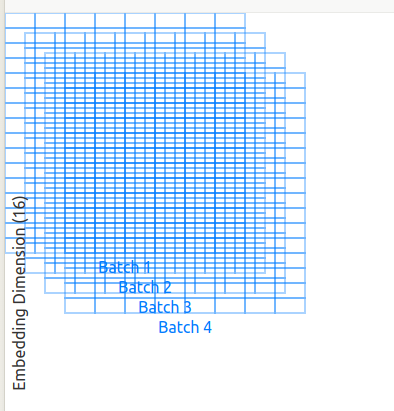

In [100]:
#version 4
torch.manual_seed(1337)
B,T,C=4,8,32
x=torch.randn(B,T,C)

#single head self attention

head_size=16
key=nn.Linear(C,head_size,bias=False)
query=nn.Linear(C,head_size,bias=False)
value=nn.Linear(C,head_size,bias=False)
k=key(x)
q=query(x)
v=value(x)
''' 
the inner dimensions must match. For two matrices A and B to be multiplied, 
the number of columns in A must equal the number of rows in B.
'''
wei=q@k.transpose(-2,-1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril=torch.tril(torch.ones(T,T))
# wei=torch.zeros((T,T))
''' 
we dont want this to be uniform(must be data dependent)
so we each token have two vectors query and key 
'''
wei=wei.masked_fill(tril==0,float('-inf')) # wei masked fill of tril 0 to -inf
wei=F.softmax(wei,dim=-1) #normilize each row 
out=wei @ v
out.shape
wei[0]


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below